# Exploratory Data Analysis and linear regression

Basé sur https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/homeworks-practice/homework-practice-02-linregr.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = 20, 5

id - a unique identifier for each trip<br>
vendor_id - a code indicating the provider associated with the trip record<br>
pickup_datetime - date and time when the meter was engaged<br>
dropoff_datetime - date and time when the meter was disengaged<br>
passenger_count - the number of passengers in the vehicle (driver entered value)<br>
pickup_longitude - the longitude where the meter was engaged<br>
pickup_latitude - the latitude where the meter was engaged<br>
dropoff_longitude - the longitude where the meter was disengaged<br>
dropoff_latitude - the latitude where the meter was disengaged<br>
store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip<br>
trip_duration - duration of the trip in seconds<br>

## 0. Etape préparatoire (2pt.)

Les données pour ce TP proviennent de la compétition kaggle [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), dont l'objectif était de prédire la durée d'un trajet en taxi.

**Devoir 0.1**. Téléchargez le dataset d'entraînement et chargez le:

In [2]:
# your code here
data=pd.read_csv("train.csv",sep=",")
data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

**Devoir 0.2**. Les valeurs de la variable `pickup_datetime` correspondent à la date et l'heure du début du trajet. Vérifiez le type de la variable et modifiez le type au `datetime`.

La variable `dropoff_datetime` a été ajoutée par les organisateurs dans le dataset d'entraînement uniquement, donc elle ne peut pas être utilisée dans un modèle de prédiction. Supprimez cette colonne.

In [3]:
# verification du type de la variable pickup_datetime
print("pickup_datetime data type : ",data.pickup_datetime.dtypes)

pickup_datetime data type :  object


In [4]:
#modification du type de la variable pickup_datetime
data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'], errors = 'coerce')
print("pickup_datetime new data type : ",data.pickup_datetime.dtypes)

pickup_datetime new data type :  datetime64[ns]


In [5]:
#suppression de la variable dropoff_datetime
data.drop(columns=["dropoff_datetime"],inplace=True)
"dropoff_datetime" in data.columns

False

**Devoir 0.3**. La variable `trip_duration` est la variable cible: ce sont ses valeurs qu'on a besoin de prédire. Vérifiez la distribution des valeurs de la variable cible à l'aide d'un histogramme :

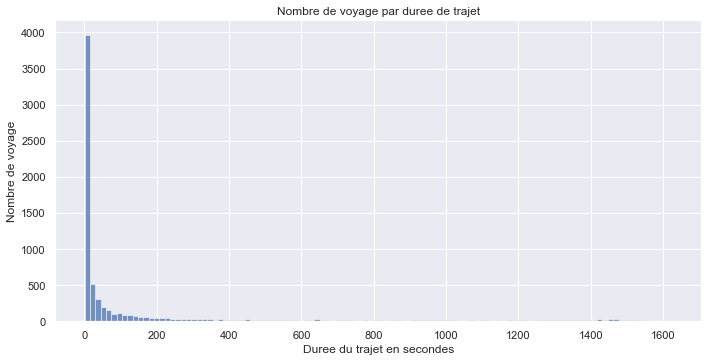

In [6]:
# your code here
data_trip_duration=data["trip_duration"]
frequence=data["trip_duration"].value_counts()
ax=sns.displot(frequence,aspect=2)
ax.set(title="Nombre de voyage par duree de trajet",xlabel="Duree du trajet en secondes",ylabel="Nombre de voyage")
plt.show()

**Question**: Que peut-on dire sur la variable cible et ses valeurs?

*Votre réponse*
<h3 style="color:red">On remarque que la plupart des voyages ont une courte duree(moins de 400 secondes).<h3>


La métrique d'évaluation utilisée dans la compétition est RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Question**: Comment pensez-vous, pourquoi les organisateurs, ont-ils choisi RMSLE et non pas RMSE?

*Votre réponse*
<h3 style="color:red">Il y a beaucoup de valeurs aberrantes pour la variable trip_duration( presque toutes les valeurs sont inferieurs a 400 et le nombre de voyage ayant une duree superieur a 400 est negligeable.) RMSLE permet de reduire le taux d'erreur due aux valeurs aberrantes.Leur effet sur le resultat est donc moindre.<h3>

**Devoir 0.4**. Le logarithme de la variable cible a des propriétés utiles. Pour le voir, créez une nouvelle variable `log_trip_duration` (utilisez la fonction `np.log1p`) et affichez l'histogramme de cette variable cible transformée. Supprimez la colonne avec la variable cible initiale.

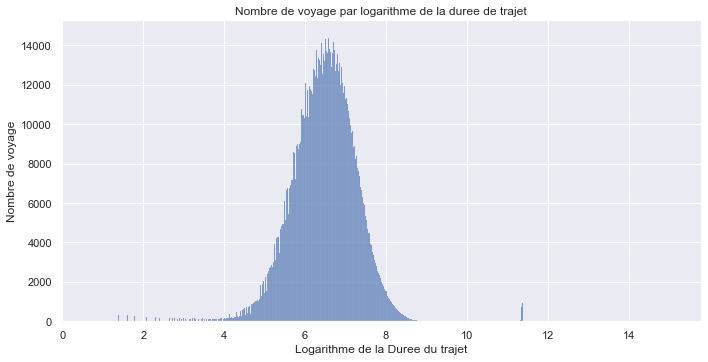

False

In [7]:
#calcul de la nouvelle variable log_trip_duration
data["log_trip_duration"]=np.log1p(data.trip_duration)
#affichage de l'histogramme
ax=sns.displot(x="log_trip_duration", data=data,aspect=2)
ax.set(title="Nombre de voyage par logarithme de la duree de trajet",xlabel="Logarithme de la Duree du trajet",ylabel="Nombre de voyage")
plt.show()
#suppression de la colonne trip_duration
data.drop(columns="trip_duration",inplace=True)
"trip_duration" in data.columns

**Devoir 0.5**. Pour avoir un point de départ, calculez la valeur de la métrique RMSLE à la meilleure prédiction constante

In [8]:
# your code here
best_const = np.expm1(np.mean(np.log1p(data['log_trip_duration'])))
best_const

6.421672815863802

## 1. Analyse de `pickup_datetime` (4pt.)

**Devoir 1.1 (0.5)** Combien de trajets par jours sont effectués? Affichez le graphique de la relation entre le nombre de trajets et la date (cela peut être fait avec la fonction `sns.countplot`, par exemple):

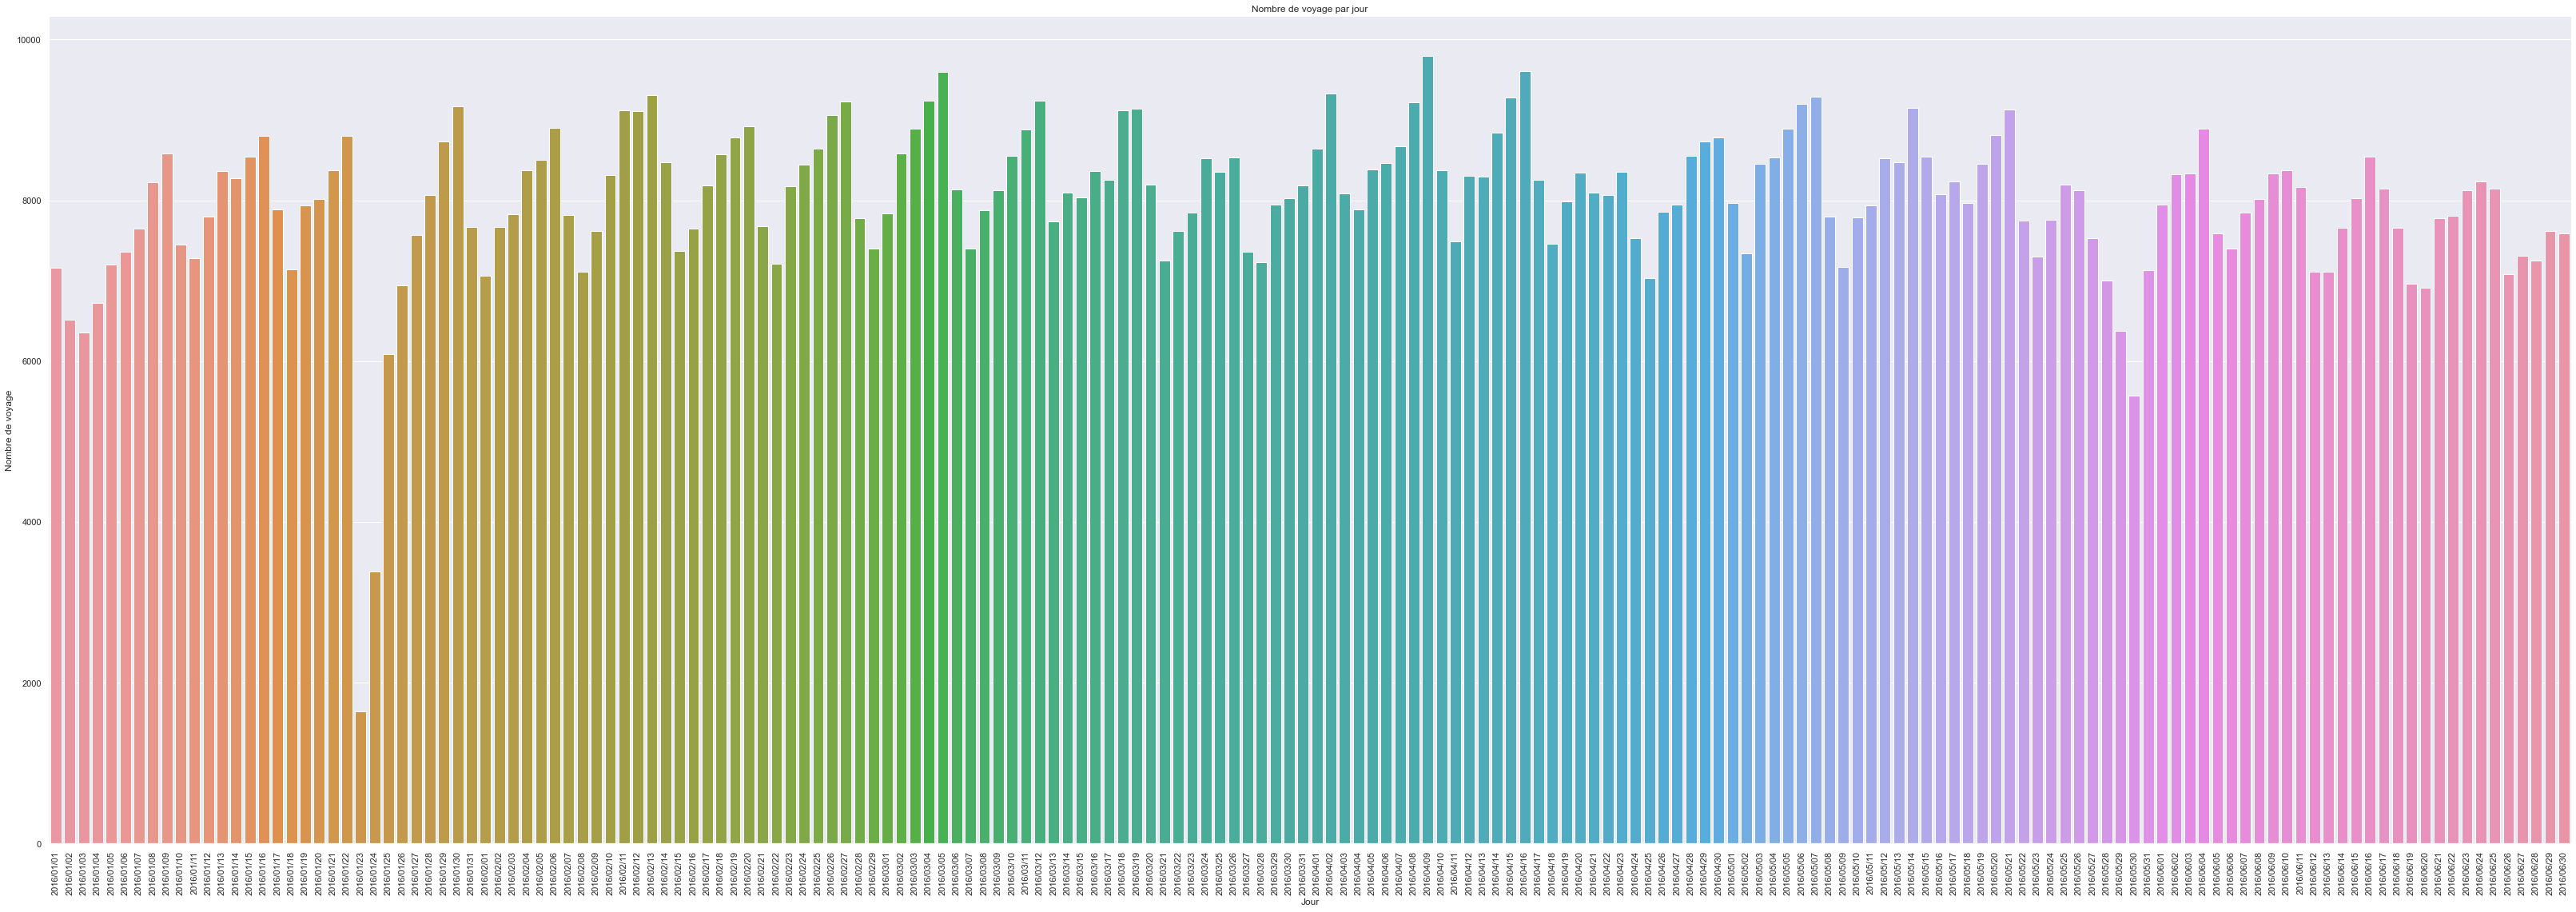

In [9]:
data1=pd.DataFrame()
data1["pickup_date"]=data.pickup_datetime.dt.strftime('%Y/%m/%d')
ax=sns.catplot(x="pickup_date",data=data1, kind="count",height=15, aspect=3,order=sorted(data1["pickup_date"].unique()))
ax.set_xticklabels(rotation=90)
ax.set(xlabel="Jour",ylabel="Nombre de voyage",title="Nombre de voyage par jour")
plt.show()

**Question**: Avez-vous remarqué 2 périodes avec un nombre trop petit de trajets par rapport nombres habituels de trajets? Vérifiez quelles sont les dates correspondantes et vérifiez s'il n'y a pas eu d'événements spécifiques à New York à ces dates pouvant expliquer ces valeurs basses.

*Votre réponse*
<h3 style="color:red">Oui, il y a deux dates dont le nombre de voyages est peu elevee par rapport au nombre de voyage habituel.<h3>

In [10]:
#les dates correspondantes sont:
data1.pickup_date.value_counts().tail(2)

2016/01/24    3383
2016/01/23    1648
Name: pickup_date, dtype: int64

<h3 style="color:red">Arrivee Le 2016/01/23, la tempete de neige Jonas tomba sur la côte Est des USA. Une quinzaine d’Etats ont été touchés, depuis la façade Atlantique (entre New York et la Caroline du Sud) jusqu’à l’Arkansas, dans le Sud.  Toute la côte fut paralysée le 2016/01/23 et le 2016/01/24 matin.</h3>

**Devoir 1.2 (1.0)** Affichez deux graphiques supplémentaires : nombre de trajets par jour de semaine et nombre de trajets par heure du jour.

Affichez le nombre  de trajets par heure du jour et jour de semaine (vous pouvez utiliser la fonction `sns.relplot`).

Pour les jours de semaine affichez bien les noms et non pas les numéros.

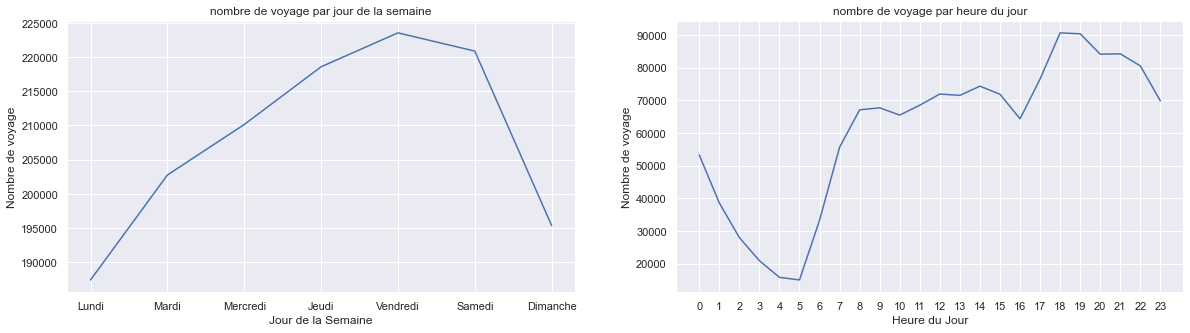

In [11]:
#nombre de voyage par jour de la semaine
#pickup_day_name=data.pickup_datetime.dt.day_name().value_counts(sort=False).reset_index().rename(columns={"index":"DayName","pickup_datetime":"NombreDeVoyage"})
pickup_day_name=data.pickup_datetime.dt.dayofweek.value_counts(sort=False).reset_index().rename(columns={"index":"DayName","pickup_datetime":"NombreDeVoyage"})
pickup_day_name["DayName"]=pickup_day_name["DayName"].map({0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'})

#nombre de voyage par heure du jour
pickup_hour=data.pickup_datetime.dt.hour.value_counts(sort=False).reset_index().rename(columns={"index":"Hour","pickup_datetime":"NombreDeVoyage"})

fig, (ax1, ax2) = plt.subplots(1, 2)
# affichage du graphique 1
sns.lineplot(x ="DayName", y ="NombreDeVoyage",data = pickup_day_name,ax=ax1)
ax1.set(xlabel="Jour de la Semaine",ylabel="Nombre de voyage", title="nombre de voyage par jour de la semaine")

# affichage du graphique 2
sns.lineplot(x ="Hour", y ="NombreDeVoyage",data = pickup_hour,ax=ax2)
ax2.set(xlabel="Heure du Jour",xticks=range(0,24),ylabel="Nombre de voyage",title="nombre de voyage par heure du jour")
plt.show()

**Devoir 1.3 (0.75)** Affichez sur un seul graphique la dépendance du nombre de trajets par rapport à l'heure dans une journée pour les mois différents (une courbe par mois). Les courbes correspondantes aux différents mois doivent être de différentes couleurs.

Affichez également un graphique de dépendance du nombre de trajets de l'heure dans la journée pour les différents jours de semaine.

In [12]:
data2=pd.DataFrame()

data2["pickup_datetime"]=data.pickup_datetime
data2["hour"]=data.pickup_datetime.dt.hour
data2["month"]=data.pickup_datetime.dt.month_name()
data2=data2.groupby(["hour","month"]).count().reset_index().rename(columns={"pickup_datetime":"NombreDeVoyage"})
#display(data2)
g=sns.relplot(y="NombreDeVoyage",x ="hour", hue ="month",data = data2,kind="line",aspect=3)
g.set(title="Dépendance du nombre de trajets par heure par mois",xlabel="Heure",ylabel="Nombre de voyage")
g.set(xticks=range(0,24))
plt.show()


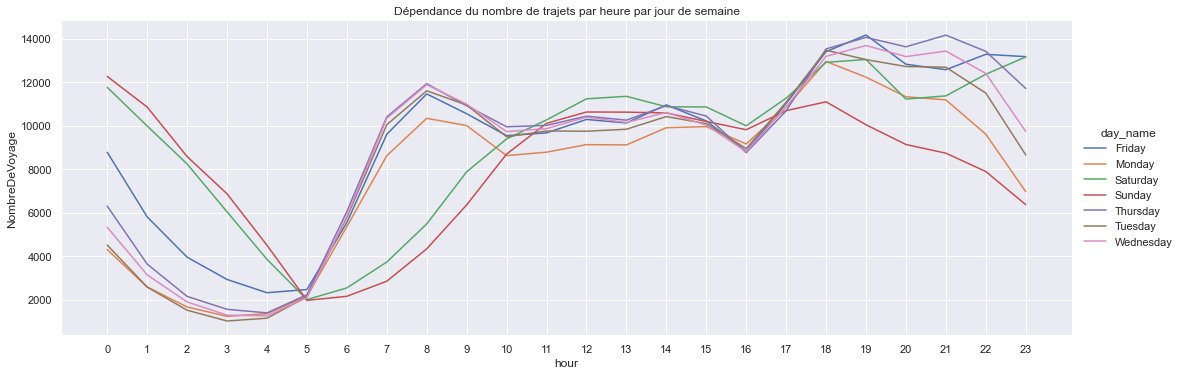

In [13]:
data3=pd.DataFrame()

data3["pickup_datetime"]=data.pickup_datetime
data3["hour"]=data.pickup_datetime.dt.hour
data3["day_name"]=data.pickup_datetime.dt.day_name()
data3=data3.groupby(["hour","day_name"]).count().reset_index().rename(columns={"pickup_datetime":"NombreDeVoyage"})
g=sns.relplot(y="NombreDeVoyage",x ="hour", hue ="day_name",data = data3,kind="line",aspect=3)
g.set(title="Dépendance du nombre de trajets par heure par jour de semaine")
g.set(xticks=range(0,24))
plt.show()

**Question**: Comment pouvez-vous interpréter les deux graphiques?

*Votre réponse*
<h3 style="color:red">
    <ul>
        <li>De maniere generale la distribution du nombre de voyage par heure est la meme dans le mois comme dans la semaine. Il y a cependant une assez grande variation dans la distribution par semaine pour le samedi et le dimanche entre 5h-10h et le dimanche entre 17h-23h ou le nombre de voyage est moins eleve par rapport aux autre jour de semaine a la meme heure.</li>
        <li>Le nombre de voyage est le plus bas a 5h et le plus eleve entre 18h et 19h </li>
        <li>entre minuit et 5h, le nombre de voyage baisse puis remonte jusqu'a 08h. Il est a peu pres constant entre 08h et 15h.</li>
        <li> entre 15h et 16h le nombre de voyage augmente jusqu'a atteindre le pic entre 18h et 19h. Ensuite il decroit mais reste plus eleve que le nombre de voyage entre minuit et 05h.</li>
        <li>Globalement,le plus grand nombre de voyage a lieu dans le mois de mars</li>
        <li>la plupart des voyages entre minuit et 05h se font le dimanche.</li>
        <li>entre 05h et 09h, les voyages les plus nombreux ont lieu le Mercredi</li>
        <li>Entre 11h et 17h, les voyages ont lieu le Samedi pour la plupart</li>
        <li>Entre 19h et 22h, les voyages ont lieu le Jeudi pour la plupart</li>
    </ul>
</h3>

**Devoir 1.4 (0.0)**. Divisez l'échantillon en deux parties : une pour l'apprentissage du modèle et l'autre pour les tests, en proportion 7:3 (cf. fonction `sklearn.model_selection.train_test_split`).

Affichez le graphique du logarithme moyen du temps de trajet en fonction du jour de la semaine. Faites la même chose en fonction de l'heure du jour et de date.

In [14]:
# Division de l'échantillon en deux parties
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.3,train_size=0.7)

In [15]:
#Affichage du graphique du logarithme moyen du temps de trajet en fonction du jour de la semaine.
data4=pd.DataFrame()
data4["weekday"]=data.pickup_datetime.dt.weekday
data4["log_trip_duration"]=data.log_trip_duration
data4=data4.groupby(["weekday"]).mean().reset_index()
data4["weekday"]=data4["weekday"].map({0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'})
graph=sns.relplot(y="log_trip_duration",x ="weekday",data = data4,kind="line",aspect=3)
graph.set(title="Evolution du logarithme moyen du temps de trajet en fonction du jour de la semaine",xlabel="Jour de Semaine",ylabel="logarithme moyen du temps du trajet")
plt.show()

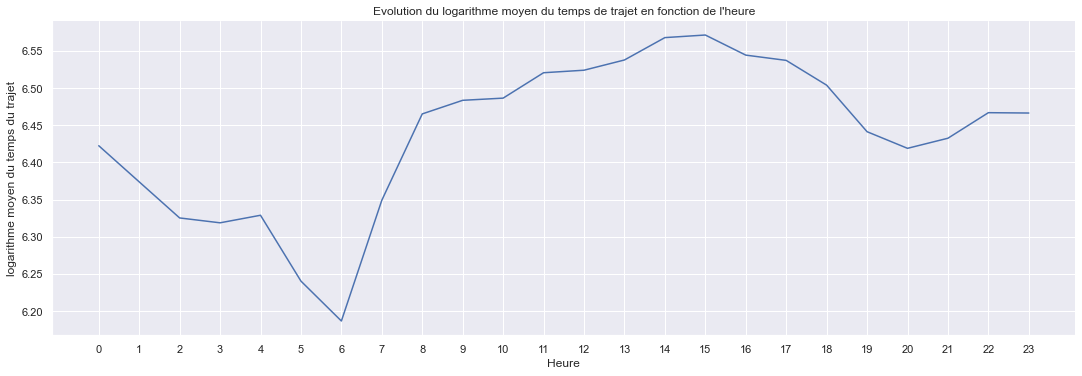

In [16]:
#Affichage du graphique du logarithme moyen du temps de trajet en fonction de l'heure du jour
data5=pd.DataFrame()
data5["log_trip_duration"]=data.log_trip_duration
data5["heure"]=data.pickup_datetime.dt.hour
data5=data5.groupby(["heure"]).mean().reset_index()
data5.head()

graph=sns.relplot(y="log_trip_duration",x ="heure",data = data5,aspect=3,kind="line")
graph.set(title="Evolution du logarithme moyen du temps de trajet en fonction de l'heure",xlabel="Heure",ylabel="logarithme moyen du temps du trajet")
graph.set(xticks=range(0,24))
plt.show()

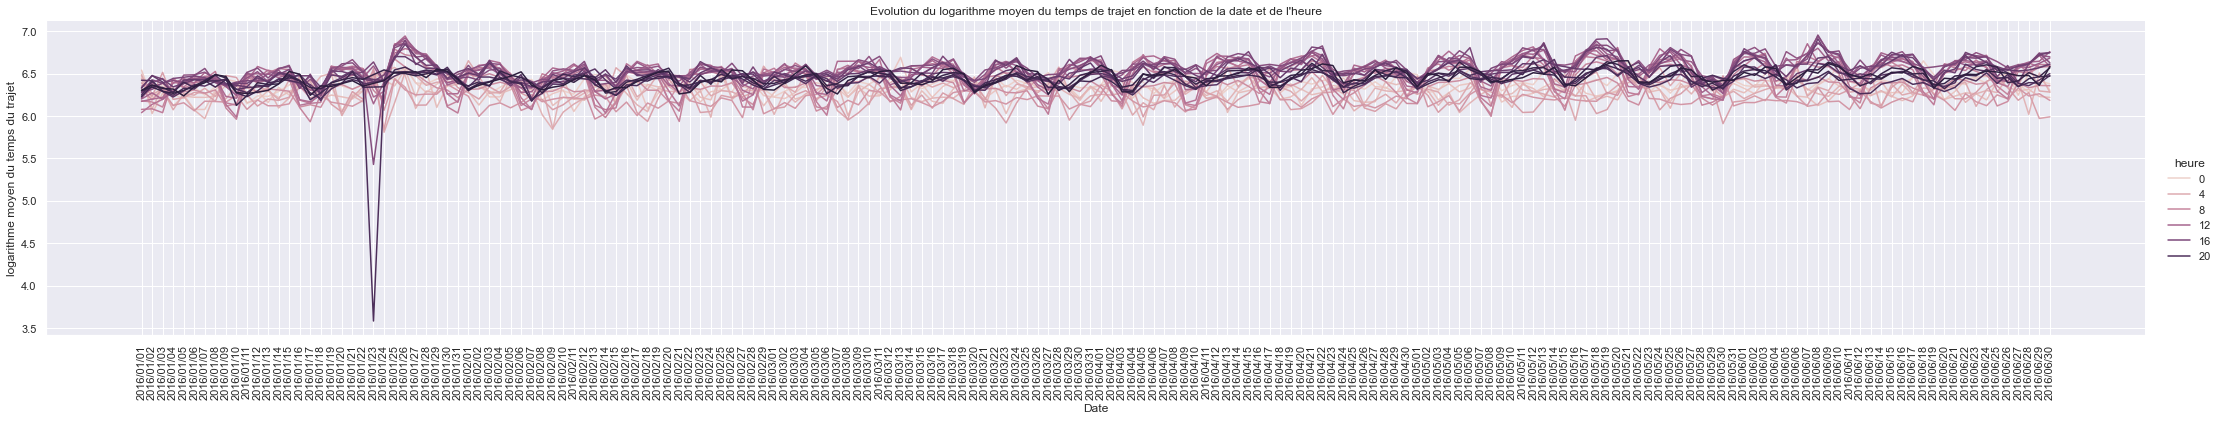

In [17]:
#Affichage du graphique du logarithme moyen du temps de trajet en fonction de l'heure du jour
data6=pd.DataFrame()
data6["log_trip_duration"]=data.log_trip_duration
data6["date"]=data.pickup_datetime.dt.strftime('%Y/%m/%d')
data6["heure"]=data.pickup_datetime.dt.hour
data6=data6.groupby(["date","heure"]).mean().reset_index()


graph=sns.relplot(y="log_trip_duration",x ="date", hue="heure",data = data6,aspect=6,kind="line")
graph.set(title="Evolution du logarithme moyen du temps de trajet en fonction de la date et de l'heure",xlabel="Date",ylabel="logarithme moyen du temps du trajet")
plt.xticks(rotation=90)
plt.show()

**Question**: Les graphiques de la dépendance de la variable cible du jour de la semaine et de l'heure dans la journée, ressemblent-ils à ceux de la distribution du nombre de déplacements ? Pourquoi? Qu'arrive-t-il à la variable cible pendant les deux périodes anormales qui étaient vus précédemment ? Pourquoi ? Voyez-vous une tendance dans le graphique de `log_trip_duration` par rapport au jour de l'année ?

*Votre réponse*
<h3 style="color:red">
Oui, Les graphiques de la dépendance de la variable cible du jour de la semaine et de l'heure dans la journée, ressemblent à ceux de la distribution du nombre de déplacements.<br><br>  
Pendant les deux periodes anormales, la duree de trajet chute brusquement a partir de 16h car les routes sont devenues impraticables et les vehicules ont du garer en urgence.<br><br>
on remarque sur le graphique de log_trip_duration que le nombre de voyage est assez constant en debut d'annee et commence a augmenter au mois de mai.
</h3>

**Devoir 1.5 (0.25)** Ajoutez des nouvelles variables basées sur `pickup_datetime`:

1.   Jour de semaine
2.   Mois
3.   Heure de la journée
4.   Si la période est "anormale" (deux variables binaires pour deux périodes détectées)
5.   Jour de l'année

In [18]:
# your code here
date_=data.pickup_datetime.dt.strftime('%Y/%m/%d')
data["dayName"]=data.pickup_datetime.dt.day_name()
data["month"]=data.pickup_datetime.dt.month_name()
data["hour"]=data.pickup_datetime.dt.hour
data["normality"]=["anormale" if (x=="2016/01/24" or x=="2016/01/23") else "normale" for x in date_ ]
data["day"]=data.pickup_datetime.dt.day
data.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  log_trip_duration    dayName    month  hour normality  \
0                  N           6.122493     Monday    March    17   normale   
1                  N           6.498282     Sunday     June     0   normale   
2                  N           7.661527    Tuesday  January    11   normale   
3                  N           6.063785  Wednesday    April    19   normale   
4                  N           6.077642   Saturday    March    13   normale   

   day  
0   14  
1   12  
2   19  
3    6  
4   26

**Question**: Lesquelles des variables faut-il considérer comme catégoriques et lesquelles cimme numériques? Pourquoi?

*Votre réponse*
<h3 style="color:red">- Variable categorique: normality, month, day_name : Elle ne permettent pas de quantifier une variables mais plutot de classer. <br>
- Variable numerique: hour,day : ce sont des variables numeriques sur lesquelles l'on peut effectuer des operations.
</h3>

**Devoir 1.6 (1.5)** Entraînez la régression de crète (`Ridge`) avec les paramètres par défaut en encodant toutes les variables catégorielles avec `OneHotEncoder`. Mettez à l'échelle les caractéristiques numériques à l'aide du `StandardScaler`. Utilisez uniquement les variables avec lesquelles nous avons travaillée dans cette section.

https://scikit-learn.org/stable/modules/linear_model.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [19]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

#transformation des variables
numeric=StandardScaler().fit_transform(data[["hour","day"]])
categoriq=OneHotEncoder().fit_transform(data[["normality","month","dayName"]]).toarray()
#decouage en test et apprentissage
X=pd.concat([pd.DataFrame(numeric),pd.DataFrame(categoriq)],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data[["log_trip_duration"]], test_size=0.3)
#test
rid = Ridge(1.0).fit(X_train, y_train)
rmsle_score=mean_squared_error(y_test,rid.predict(X_test),squared=False)
print(rmsle_score)


#X=pd.DataFrame()
#X["hour"]=list(StandardScaler().fit_transform(data[["hour"]])[:,0])
#X["day"]=list(StandardScaler().fit_transform(data[["day"]])[:,0])
#X["month"] = list(OneHotEncoder().fit_transform(data[["month"]]).toarray()[:,0])
#X["dayName"] =  list(OneHotEncoder().fit_transform(data[["dayName"]]).toarray()[:,0])
#y=data[["log_trip_duration"]]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#rid = Ridge(1.0).fit(X_train, y_train)
#rmsle_score=mean_squared_error(y_test,rid.predict(X_test),squared=False)
#print(rmsle_score)
#r2_score(y_test, rid.predict(X_test))

0.7917067834285126


## 2. Analyse des coordonnées (6pt.)
Vous avez bien exploré les données sur le début du trajet, il est temps de travailler avec les coordonnées du point de départ et du point d'arrivée. Ci-dessous vous trouverez la définition de la fonction `show_circles_on_map` qui affiche sur une carte les points de départ et d'arrivée. Exemples d'appel de cette fonction se trouve ci-dessous également. On ne passe pas dans la fonction toutes les données disponibles mais un échantillon pour le temps d'éxecution moins long.

Installez la librairie `folium` pour visualiser les cartes géographiques.

In [20]:
!pip install folium

In [21]:
import folium

m = folium.Map(location=(43.44626936228708, -1.553731439410459), zoom_start=50)
m

In [22]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [23]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [24]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Question**: Y a-t-il des points très différents de l'ensemble de points affichés ?

*Votre réponse*
    <h3 style="color:red">Oui, il y a des points qui sont tres differents de l'ensemble de points affiches. Ces points sont excentrés.</h3>

**Devoir 2.1 (1.5)** La durée du trajet dépend de la distance et du temps : $t = s / v_{\text{mean}}$, c'est pourquoi il est évident que la distance sera la variable la plus importante pour la prédiction de la durée. On ne peut pas alculer la distance exacte correspondante à un trajet, mais on peut l'estimer en calculant la distance minimale entre les points de départ et d'arrivée. Pour calculer correctement la distance entre deux points sur la Terre, on peut utiliser la fonction `haversine`. Ajoutez une nouvelle colonne avec la distance calculée à l'aide de la fonction `haversine` :

In [25]:
def haversine(lat1, lng1, lat2, lng2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [26]:
# your code here
data["distance_km"]=data.apply(lambda row: haversine(row.pickup_latitude,row.pickup_longitude,row.dropoff_latitude,row.dropoff_longitude), axis=1)

Puisque la variable cible c'est le logarithme de la durée de trajet et afin d'essayer de construire un modèle linéaire pour prédire ces valeurs, il est nécessaire de calculer le logrithme de la distance: $\log t = \log s - \log{v_{\text{mean}}}$. Ajoutez une colonne supplémentaire avec le logarithme de `haversine`:

In [27]:
# your code here
data["log_distance_km"]=np.log1p(data["distance_km"])

Vérifiez si le logarithme de la distance corrèle mieux avec la variable cible par rapport à la distance:

In [28]:
# your code here
print("correlation entre log_trip_duration et la distance",data['log_trip_duration'].corr(data['distance_km']))
print("correlation entre log_trip_duration et le logarithme de la distance",data['log_trip_duration'].corr(data['log_distance_km']))

correlation entre log_trip_duration et la distance 0.5735948311180125
correlation entre log_trip_duration et le logarithme de la distance 0.7498822373942492


<h3 style="color:red">Le logarithme de la distance a une meilleure correlation avec la variable cible que la distance elle-meme</h3>

**Devoir 2.2 (1.5)** Calculez la vitesse moyenne des trajets trajet de l'échantillon d'apprentissage : `haversine` divisée par `trip_duration`. Affichez un histogramme de distribution des valeurs de la vitesse moyenne.

In [29]:
# your code here
v_haversine=data_train.apply(lambda row: haversine(row.pickup_latitude,row.pickup_longitude,row.dropoff_latitude,row.dropoff_longitude), axis=1)
trip_duration=np.expm1(data_train.log_trip_duration)
vitesse_moyenne=v_haversine/trip_duration
ax=sns.displot(vitesse_moyenne,aspect=3)
ax.set(title="histogramme de distribution des valeurs de la vitesse moyenne")
plt.show()                                      

Comme vous pouvez le constater avec ce histogramme, pour certains trajets les valeurs de la vitesse moyenne sont aberrantes. Affichez l'histogramme en filtrant des données sources, par exemple en enlevant les valeurs supérieurs à certains percentiles:

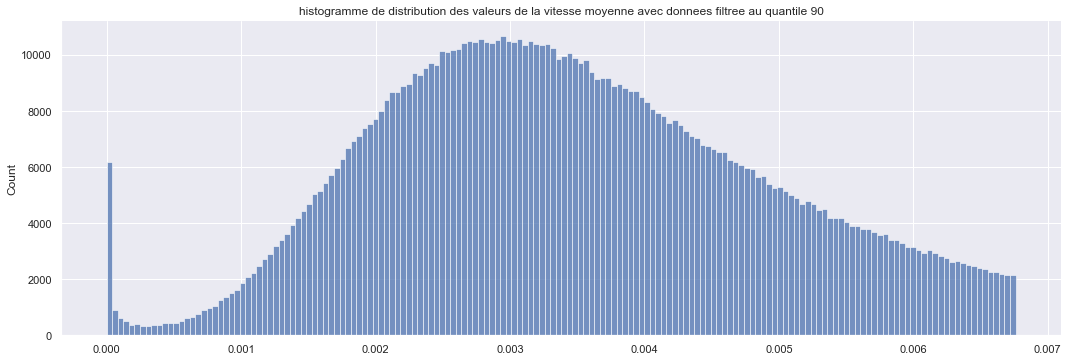

In [31]:
quantile_90=vitesse_moyenne.quantile(0.9)
data_quantile_90=[ x for x in vitesse_moyenne if x< quantile_90]
ax=sns.displot(data_quantile_90,aspect=3)
ax.set(title="histogramme de distribution des valeurs de la vitesse moyenne avec donnees filtree au quantile 90")
plt.show()

Pour chaque tuple (jour de la semaine, heure dans la journée) calculez la médiane des vitesses. Affichez un heatmap avec le résultats obtenus.

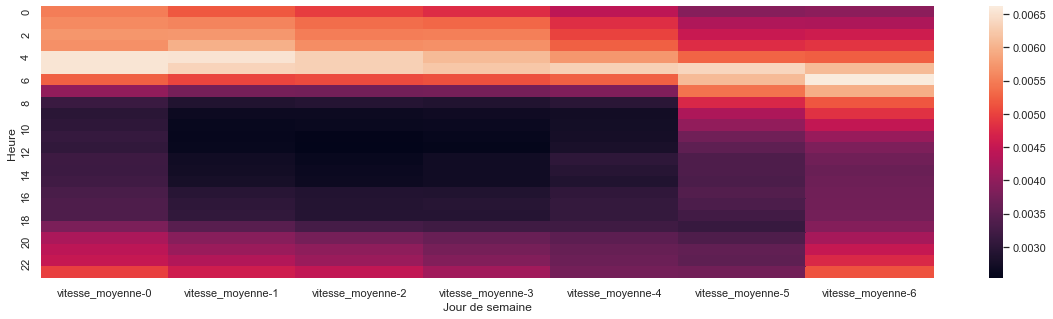

In [32]:
# your code here
train_=pd.DataFrame()
train_["vitesse_moyenne"]=vitesse_moyenne
train_["weekday"]=data_train.pickup_datetime.dt.weekday
#train_["weekday"]=train_["weekday"].map({0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'})
train_["hour"]=data_train.pickup_datetime.dt.hour 
train_=train_.groupby(["weekday","hour"]).quantile(0.5)
ax=sns.heatmap(train_.unstack(level=0))
ax.set(xlabel="Jour de semaine")
ax.set(ylabel="Heure")
plt.show()

**Attention** : La variable contenant la vitesse doit être supprimée avant l'apprentissage du modèle (cf. https://en.wikipedia.org/wiki/Multicollinearity).

**Question**: Comment pouvez-vous interpréter le graphque précédent : à quels moments la vitesse est-elle minimale et à quels moments est-elle maximale ?

*Votre réponse*
<h3 style="color:red">
    - du lundi au vendredi, La vitesse est maximal entre [4h et 6h]. elle devient minimal entre [7h et 18h] <br>
    - le samedi, La vitesse est maximal entre 4h et 5h. elle devient minimal entre 18h et 19h<br>
    - le dimanche, La vitesse est maximal entre 5h et 6h. elle devient minimal entre 18 et 17h
</h3>

Ajoutez les variables "trajet avec des embouteillages" et "trajet avec la vitesse maximale" (elles ne doivent pas dépendre de la vitesse) :

In [33]:
# your code here
list_jour=['Monday',  'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']
list_heure_embouteillage_lun_ven=list(range(7,19))

data["duree_en_heure"]=trip_duration/3600#toutes les valeurs sont inferieur a 24 donc un voyage a lieu au maximum deux jour de suite
data["duree_en_heure"].fillna(0, inplace=True)

def check_if_embouteillage(jour,list_heur_voyage):
    v_embouteillage=False
    #du lundi au vendredi, entre 07h et 18h il y a embouteillage
    if jour in list_jour[0:5]  and  any(item in list_heur_voyage for item in list_heure_embouteillage_lun_ven):#on verifie dans la liste des heure de voyage si il y a au moins une heure d'embouteillage         
        v_embouteillage=True
    #le samedi, il y a embouteillage entre 18h et 19h
    elif jour == "Saturday" and any(item in list_heur_voyage for item in [18,19]):
        v_embouteillage=True
    #le dimanche, il y a embouteillage entre 17h et 18h
    elif any(item in list_heur_voyage for item in [18,17]):
        v_embouteillage=True
        
    return v_embouteillage

def check_if_v_max(jour,list_heur_voyage):
    v_max=False
    #du lundi au vendredi, entre 04h et 6h il y a vitesse maximal
    if jour in list_jour[0:5]  and  any(item in list_heur_voyage for item in [4,6]):#on verifie dans la liste des heure de voyage si il y a au moins une heure d'embouteillage         
        v_max=True
    #le samedi, il y a v_max entre 4h et 5h
    elif jour == "Saturday" and any(item in list_heur_voyage for item in [4,5]):
        v_max=True
    #le dimanche, il y a v_max entre 5h et 6h
    elif any(item in list_heur_voyage for item in [5,6]):
        v_max=True
        
    return v_max

def cat(row):
    

    jour_depart=row.dayName
    heur_depart=row.hour
    
    jour_arriv=row.dayName
    heur_arriv=int(heur_depart+row.duree_en_heure)
    
    list_heure_voyage_j1=list(range(heur_depart,heur_arriv+1))
    #list_heure_voyage_j1=[x for x in list_heure_voyage_j1 if x<24]
    
    #verifie si presence d embouteillage jour 1
    v_embouteillage=check_if_embouteillage(jour_depart,list_heure_voyage_j1)
    #verifie si presence de v_max jour 1
    v_max=check_if_v_max(jour_depart,list_heure_voyage_j1)
    
     #voyage de plus d'un jour
    if heur_arriv>=24 :
        heur_arriv=heur_arriv%24
        jour_arriv= "Monday" if jour_arriv=="Sunday" else list_jour[list_jour.index(jour_arriv)+1]
        list_heure_voyage_j2=list(range(0,heur_arriv+1))
        #verifie si presence d embouteillage jour 2
        v_embouteillage= v_embouteillage or check_if_embouteillage(jour_arriv,list_heure_voyage_j2)  
         #verifie si presence de v_max jour 2
        v_max=v_max or check_if_v_max(jour_arriv,list_heure_voyage_j2)
        
        
    return v_embouteillage,v_max
    
iny=data.apply(lambda row : cat(row),axis=1) 
data["trajet_avec_des_embouteillages"]=[x[0] for x in iny]
data["trajet_avec_la_vitesse_maximale"]=[x[1] for x in iny]

data.drop(columns="duree_en_heure",inplace=True)

**Devoir 2.3 (0.5)** Sur la carte on a vu des points éloignés de Manhattan. Pour les trajets correspondants ajoutez des nouvelles features: si le trajet a commencé dans le point de départ éloigné ou bien si c'était le point de destination.

In [34]:
# your code here
distance_eloigne_km=10;#90% des trajets avec points les plus distants ont une distance inferieur a 10km de mahathan
def calcul_distance_from_manhattan(longitude1,latitude1,longitude2,latitude2):

    long_man=-73.9712488
    lat_man=40.7830603
    distance1=haversine(lat_man,long_man,latitude1,longitude1)
    distance2=haversine(lat_man,long_man,latitude2,longitude2)
    
    point_eloigne= 1 if abs(distance1) > abs(distance2) else 2
    distance = distance1 if point_eloigne==1 else distance2
    #1 si le point 1 est eloigne de manhattan
    #2 si c'est le point 2
    #0 si les deux points ne sont pas eloignes
    statut=point_eloigne  if distance >= distance_eloigne_km else 0
    
    return [point_eloigne, distance, statut]
    
info_dist_man=data.apply(lambda row : calcul_distance_from_manhattan(row.pickup_longitude,row.pickup_latitude,row.dropoff_longitude,row.dropoff_latitude),axis=1)

data["etat_distance_manhattan"]=[x[2] for x in info_dist_man]
#sauvegarde des info
data_save_man=pd.DataFrame()
data_save_man["point_eloigne"]=[x[0] for x in info_dist_man]
data_save_man["distance_man"]=[x[1] for x in info_dist_man]

data_save_man.distance_man.quantile([0.7,0.8,0.9,0.95,0.98])

0.70     6.653795
0.80     7.797254
0.90     9.271094
0.95    12.348592
0.98    21.794803
Name: distance_man, dtype: float64

Pour chaqune des variables ajoutées affichez des box plots de distribution du logarithme du temps du trajet.

In [35]:
# your code here

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
sns.boxplot(x="trajet_avec_des_embouteillages",y="log_trip_duration",data=data,ax=ax1)
sns.boxplot(x="trajet_avec_la_vitesse_maximale",y="log_trip_duration",data=data,ax=ax2)
sns.boxplot(x="etat_distance_manhattan",y="log_trip_duration",data=data,ax=ax3)
plt.show()

**Question**: en regardant les graphiques, pouvez-vous dire que ces variables sont utiles?

*Votre réponse*
<h3 style="color:red">La variable etat_distance_manhattan est importante car on remarque que la distribution de la variable cible varie en fonction de chaque valeur prise par cette variable.<br><br>Concernant les deux autres variables, on remarque une legere variation egalement.<br><br> Ces variables sont donc utile.</h3>

**Devoir 2.4 (2.0)** Déterminez un rectangle de coordonnées de points de départ et de points d'arrivée avec le maximum de trajets (par forcément le nombre total de trajets). Divisez ce rectangle avec une grille sur des cellules numérotées. Choisissez vous-mêmes le nombre de lignes et de colonnes dans la grille. A chaque point sur la carte correspond un numéro de cellule, pour les points ne correpondant à aucune cellule la valeur est -1.

Ajoutez deux variables : le numéro de la cellule pour le point de départ et le numéro de la cellule pour le point d'arrivée.

In [ ]:
# your code here

**Devoir 2.5 (0.5)** Entraînez la régression de crète (`Ridge`) avec les paramètres par défaut en encodant toutes les variables catégorielles avec `OneHotEncoder`. Mettez à l'échelle les caractéristiques numériques à l'aide du `StandardScaler`. Utilisez uniquement les variables avec lesquelles nous avons travaillée dans cette section.

In [36]:
a_numeric=StandardScaler().fit_transform(data[["log_distance_km","hour"]])
a_categoriq=OneHotEncoder().fit_transform(data[["dayName","trajet_avec_des_embouteillages","trajet_avec_la_vitesse_maximale","etat_distance_manhattan"]]).toarray()
#decouage en test et apprentissage
X_2=pd.concat([pd.DataFrame(a_numeric),pd.DataFrame(a_categoriq)],axis=1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, data[["log_trip_duration"]], test_size=0.3)
#test
rid_2 = Ridge(1.0).fit(X_train_2, y_train_2)
rid_2_prediction=rid_2.predict(X_test_2)
rmsle_score_2=mean_squared_error(y_test_2,rid_2_prediction,squared=False)
print(rmsle_score_2)

0.49978848725208846


## 3. Analyse d'autres variables (2pt.)

**Devoir 3.1 (1.5)** Il vous reste 3 variables non explorées: `vendor_id`, `passenger_count` et `store_and_fwd_flag`. Affichez les valeurs uniques de chacune de ces trois variables et le nombre de trajets correspondant.

In [37]:
# your code here
print("Valeur unique de vendor_id:",set(data.vendor_id))
print("Valeur unique de passenger_count:",set(data.passenger_count))
print("Valeur unique de store_and_fwd_flag:",set(data.store_and_fwd_flag))
display(data[["vendor_id","id"]].groupby(["vendor_id"]).count().reset_index().rename(columns={"id":"NombreTrajet"}))
display(data[["passenger_count","id"]].groupby(["passenger_count"]).count().reset_index().rename(columns={"id":"NombreTrajet"}))
display(data[["store_and_fwd_flag","id"]].groupby(["store_and_fwd_flag"]).count().reset_index().rename(columns={"id":"NombreTrajet"}))

Valeur unique de vendor_id: {1, 2}
Valeur unique de passenger_count: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Valeur unique de store_and_fwd_flag: {'Y', 'N'}


vendor_id  NombreTrajet
0          1        678342
1          2        780302

passenger_count  NombreTrajet
0                0            60
1                1       1033540
2                2        210318
3                3         59896
4                4         28404
5                5         78088
6                6         48333
7                7             3
8                8             1
9                9             1

store_and_fwd_flag  NombreTrajet
0                  N       1450599
1                  Y          8045

**Question**: Comment pensez-vous, pourquoi chacune de ces trois variables peut être potentiellement utile (la description des variables est disponible sur kaggle).

*Votre réponse*
<h3 style="color:red">Avec la variable passenger_count, on peut verifier les tendances des personnes a voyager seul ou a plusieurs.<br><br>La variable vendor_id permet de savoir quel est la compagnie prefere des voyageurs. on peut aussi verifier si le nombre de personne qui voyage n'influene pas le choix de la compagnie.<br><br>la variable store_and_fwd_flag peut permettre de verifier si le trajet a lieu dans une zone eloigne(non connecte)</h3>

Affichez des box plots de distribution du logarithme de la durée du trajet par rapports aux valeurs de ces variables : `vendor_id`, `passenger_count` et `store_and_fwd_flag`

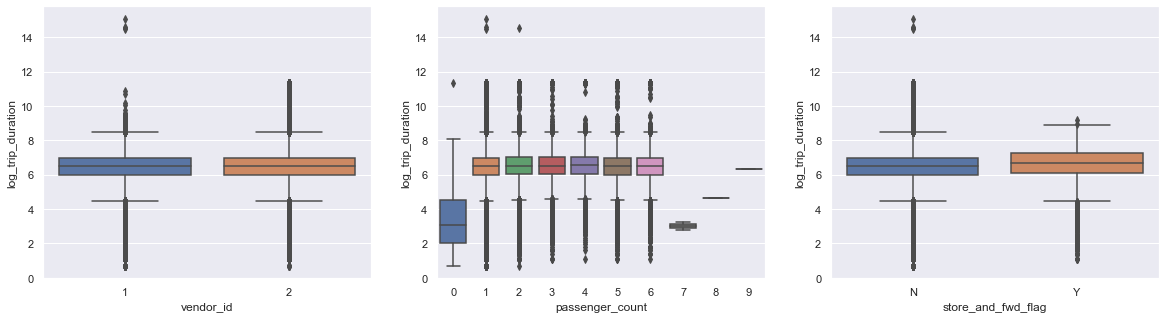

In [38]:
# your code here
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
sns.boxplot(x="vendor_id",y="log_trip_duration",data=data,ax=ax1)
sns.boxplot(x="passenger_count",y="log_trip_duration",data=data,ax=ax2)
sns.boxplot(x="store_and_fwd_flag",y="log_trip_duration",data=data,ax=ax3)
plt.show()

Modifiez les variables `vendor_id` et `store_and_fwd_flag` pour que leurs valeurs soient : $\{0;1\}$

In [39]:
# your code here
data["vendor_id"]=[0 if x==1 else 1 for x in data.vendor_id]
data["store_and_fwd_flag"]=[0 if x=="N" else 1 for x in data.store_and_fwd_flag]

**Question**: En regardant les graphiques pour ces variables, pensez-vous qu'elles peuvent être des paramètres forts du modèle ?

*Votre réponse*
<h3 style="color:red">Ces variables ne peuvent pas etre des parametres fort du modeles car la distribution de la variable cible est la meme quel que soit la valeur prise par chacune de ces variables.</h3>

**Devoir 3.2 (0.5)** Pour vérifier vos hypothèses, entraînez la régression de crète (`Ridge`) avec les paramètres par défaut en encodant toutes les variables catégorielles avec `OneHotEncoder`. Mettez à l'échelle les caractéristiques numériques à l'aide du `StandardScaler`. Utilisez uniquement les variables avec lesquelles nous avons travaillée dans cette section.

In [40]:
# your code here
a_categoriq=OneHotEncoder().fit_transform(data[["vendor_id","passenger_count","store_and_fwd_flag"]]).toarray()
#decouage en test et apprentissage
X_=pd.DataFrame(a_categoriq)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, data[["log_trip_duration"]], test_size=0.3)
#test
rid_ = Ridge(1.0).fit(X_train_, y_train_)
rmsle_score=mean_squared_error(y_test_,rid_.predict(X_test_),squared=False)
print(rmsle_score)

0.7953671851964818


Si les nouvelles variables n'ont pas permis d'améliorer la qualité du modèle, vous pouvez les supprimer.

In [41]:
data.drop(columns=["vendor_id","passenger_count","store_and_fwd_flag"],inplace=True)
data.columns

Index(['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'log_trip_duration', 'dayName',
       'month', 'hour', 'normality', 'day', 'distance_km', 'log_distance_km',
       'trajet_avec_des_embouteillages', 'trajet_avec_la_vitesse_maximale',
       'etat_distance_manhattan'],
      dtype='object')

## 4. Amélioration du modèle (6pt.)

**Devoir 4.1 (2.0)** Nos données contiennent des objets atypiques : avec la durée du trajet anormalement courte, avec une très longue distance parcourue, ou avec des résidus de régression très importants. Affichez des histogrammes des variables mentionnées ci-dessus, sélectionnez des observations correspondants aux valeurs de ces variables pouvant être considérées comme aberrantes et effacez-les de l'échantillon.

Notez que bien que ces valeurs paraissent aberrantes, l'échantillon de test contiendra très probablement des objets avec les valeurs "aberrantes" de la variable cible et/ou des autres variables. Par conséquent, il est possible que le nettoyage de l'échantillon d'apprentissage entraîne une détérioration de la qualité du test. Cependant, il est toujours préférable de supprimer les valeurs aberrantes pour rendre le modèle plus interprétable.

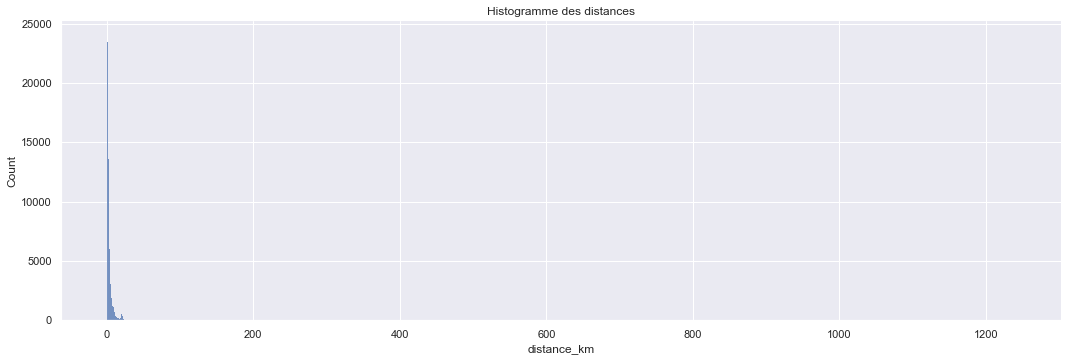

In [42]:
# your code here
ax=sns.displot(data.distance_km,aspect=3)
ax.set(title="Histogramme des distances")
plt.show()

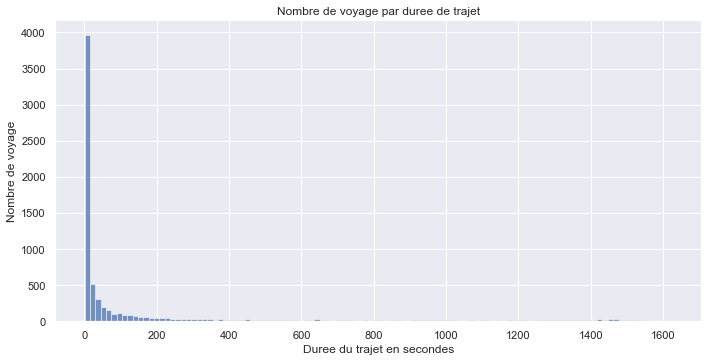

In [44]:
#la variable frequence a ete cree dans la partie 0.3
data["trip_duration"]=np.expm1(data.log_trip_duration)
ax=sns.displot(frequence,aspect=2)
ax.set(title="Nombre de voyage par duree de trajet",xlabel="Duree du trajet en secondes",ylabel="Nombre de voyage")
plt.show()

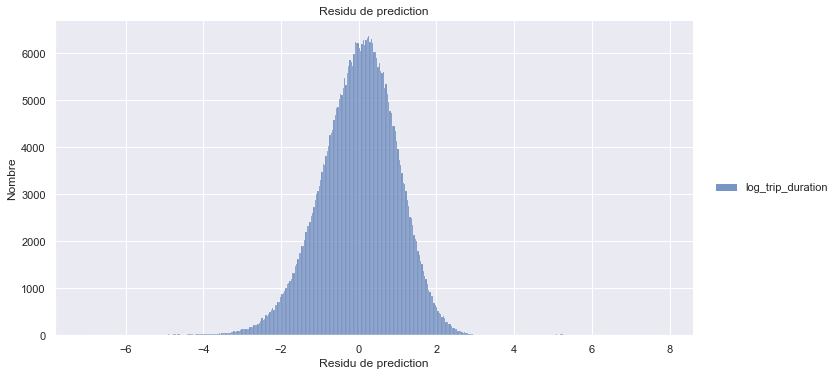

In [45]:
#la variable frequence a ete cree dans la partie 0.3
ax=sns.displot(y_test - rid_2_prediction,aspect=2)
ax.set(title="Residu de prediction",xlabel="Residu de prediction",ylabel="Nombre")
plt.show()

In [46]:
data_train_final, data_test_final = train_test_split(data, test_size=0.3,train_size=0.7)

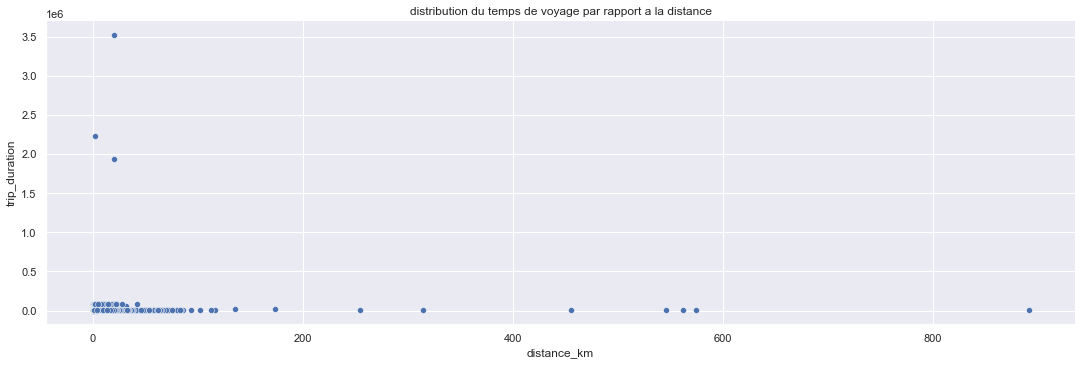

In [47]:
g=sns.relplot(y="trip_duration",x ="distance_km",data = data_train_final,aspect=3)
g.set(title="distribution du temps de voyage par rapport a la distance")
plt.show()

In [48]:
display(data_train_final.trip_duration.quantile([0.7,0.75,0.8,0.85,0.87,0.9,0.95]))
q_retenu=data_train_final.trip_duration.quantile(0.85)
q_retenu

0.70     968.0
0.75    1075.0
0.80    1208.0
0.85    1382.0
0.87    1470.0
0.90    1634.0
0.95    2106.0
Name: trip_duration, dtype: float64

1382.0000000000005

In [49]:
#effacer les valeurs aberrantes
data_train_final=data_train_final.loc[(data_train_final['trip_duration']<q_retenu)]
data_train_final=data_train_final.loc[data_train_final["distance_km"] >0]

Il y a beaucoup de variables catégorielles. Certaines catégories sont très rares et cela entraîne souvent un overfitting. Essayez de réunir des catégories (très) rares en moins de catégories.

In [50]:
display(data_train_final["dayName"].value_counts(normalize=True),
data_train_final["month"].value_counts(normalize=True),
data_train_final["normality"].value_counts(normalize=True),
data_train_final["trajet_avec_des_embouteillages"].value_counts(normalize=True),
data_train_final["trajet_avec_la_vitesse_maximale"].value_counts(normalize=True),
data_train_final["etat_distance_manhattan"].value_counts(normalize=True))

Saturday     0.155912
Friday       0.151374
Thursday     0.144979
Wednesday    0.141254
Sunday       0.138620
Tuesday      0.137688
Monday       0.130173
Name: dayName, dtype: float64

March       0.177557
April       0.171348
February    0.167254
May         0.166458
January     0.161239
June        0.156144
Name: month, dtype: float64

normale     0.996371
anormale    0.003629
Name: normality, dtype: float64

False    0.550257
True     0.449743
Name: trajet_avec_des_embouteillages, dtype: float64

False    0.957371
True     0.042629
Name: trajet_avec_la_vitesse_maximale, dtype: float64

0    0.968588
2    0.021828
1    0.009584
Name: etat_distance_manhattan, dtype: float64

In [51]:
data_train_final.columns

Index(['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'log_trip_duration', 'dayName',
       'month', 'hour', 'normality', 'day', 'distance_km', 'log_distance_km',
       'trajet_avec_des_embouteillages', 'trajet_avec_la_vitesse_maximale',
       'etat_distance_manhattan', 'trip_duration'],
      dtype='object')

Entraînez le modèle sur les données nettoyées et évaluez sa qualité.

In [52]:
# tour code here
v_numeric=StandardScaler().fit_transform(data_train_final[["log_distance_km","hour"]])
v_categoriq=OneHotEncoder().fit_transform(data_train_final[["dayName","trajet_avec_des_embouteillages","trajet_avec_la_vitesse_maximale","etat_distance_manhattan"]]).toarray()
X_final_train=pd.concat([pd.DataFrame(v_numeric),pd.DataFrame(v_categoriq)],axis=1)

#test
rid_2_final_ = Ridge(1.0).fit(X_final_train, data_train_final["log_trip_duration"])

v_numeric_test=StandardScaler().fit_transform(data_test_final[["log_distance_km","hour"]])
v_categoriq_test=OneHotEncoder().fit_transform(data_test_final[["dayName","trajet_avec_des_embouteillages","trajet_avec_la_vitesse_maximale","etat_distance_manhattan"]]).toarray()
X_final_test=pd.concat([pd.DataFrame(v_numeric_test),pd.DataFrame(v_categoriq_test)],axis=1)

#prediction
prediction_final=rid_2_final_.predict(X_final_test)
rmsle_score_final=mean_squared_error(data_test_final["log_trip_duration"],prediction_final,squared=False)
print(rmsle_score_final)

0.5643397994838362


**Devoir 4.2 (2.0)** Essayez la regression `Lasso` au lieu de `Ridge`. Quel modèle donne des meilleurs résultats ?

https://scikit-learn.org/stable/modules/linear_model.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [53]:
# your code here
from sklearn.linear_model import Lasso
las = Lasso(1.0).fit(X_final_train, data_train_final["log_trip_duration"])
prediction_final_lasso=las.predict(X_final_test)
mean_squared_error(data_test_final["log_trip_duration"],prediction_final_lasso,squared=False)

0.8196870681964034

<h3 style="color:red">Le modele Ridge est le meilleur model</h3>

**Devoir 4.3 (2.0)** 

Souvent il peut être utile de créer des nouvelles variables à partir des existantes, comme par exemple la zone de départ et la zone d'arrivée introduites ci-dessus. 

Comptez combien de fois chaque paire de zone de départ et zone d'arrivée apparaît dans l'échantillon de données et sélectionnez un certain nombres de paires les plus fréquentes. Créer une nouvelle variable catégorielle à partir de ces informations.

**Question**: Pourquoi cette variable peut être potentiellement utile ? Pourquoi le modèle linéaire ne peut pas extraire cette information lui-même en se basant sur les numéros des zones de départ et d'arrivée?

*Votre réponse*

Entraînez à nouveau le modèle (`Ridge` ou `Lasso` - celui qui a donné les meilleurs résultats) sur les nouvelles données et évaluez sa qualité sur l'échantillon test.

In [ ]:
# your code here